# Resultados
## Análisis de datos

En este archivo se encuentran el desarrollo del código con el análisis de los datos.

In [109]:
# Importamos las paqueterías importantes para el manejos de datos y de gráficos

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn import cluster
# Leemos la ubicación de la carpeta para poder leer los archivos

path = os.getcwd()
os.chdir(path)

Posteriormente leemos la base de datos a utilizar, como se mencionó en el marco teórico, solo vamos a tomar un subconjunto de columnas que son relevantes

In [80]:
# Leemos los datos
raw_data = pd.read_csv('paises.csv',decimal=',')

# Tomamos el subconjunto de datos de interés
df = raw_data.iloc[:,[4,6,7,8,9,11,12,15,16,17,18,19]].copy()
nombres = ['densidad poblacional', 'migración neta', 'mortalidad infantil', 
           'PIB per capita', 'alfabetizacion', 'arable', 'cultivado', 'tasa natilidad', 'tasa mortalidad', 'agricultura',
          'industria', 'servicios']
df.columns = nombres

La base de datos contiene varios datos faltantes, calculamos el porcentaje de ellos para cada columna

In [62]:
df.isnull().sum()/len(df)

Pop. Density (per sq. mi.)            0.000000
Net migration                         0.013216
Infant mortality (per 1000 births)    0.013216
GDP ($ per capita)                    0.004405
Literacy (%)                          0.079295
Arable (%)                            0.008811
Crops (%)                             0.008811
Birthrate                             0.013216
Deathrate                             0.017621
Agriculture                           0.066079
Industry                              0.070485
Service                               0.066079
dtype: float64

Observamos que en ningún caso se acerca al 10% de datos faltantes, por lo que vamos a hacer imputación de datos faltantes. Usamos el algoritmo de imputación de vecinos más cercanos de la paquetería *sklearn*. Usamos 2 vecinos para reducir el ruido sin generar imputaciones muy lejanas entre sí.

In [85]:

df = pd.DataFrame(KNNImputer(n_neighbors=2, weights = 'uniform').fit_transform(df))
df.columns = nombres

Ahora, es necesario normalizar los datos a fin que tengan pesos iguales las variables del modelo y así no produzca resultados irregulares el algoritmo.

In [132]:

df_normalizado = pd.DataFrame(Normalizer().fit_transform(df))

Realizamos un gráfico T-SNE para estudiar la distribución de los datos

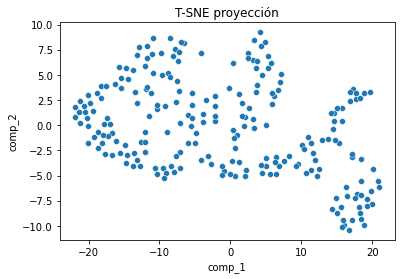

In [133]:

tsne = TSNE(learning_rate= 50, random_state=123, perplexity=25).fit_transform(df_normalizado)
df_normalizado['comp_1'] = tsne[:,0]
df_normalizado['comp_2'] = tsne[:,1]

sns.scatterplot(x="comp_1", y="comp_2", data=df_normalizado).set(title="T-SNE proyección")
df_normalizado.drop('comp_1', inplace=True, axis=1)
df_normalizado.drop('comp_2', inplace=True, axis=1)

Observamos que los datos tienen una tendencia a estar muy dispersos. Es difícil determinar el número de clusters principales, pues los puntos no están suficientemente agrupados ni dispersos. Vemos en el extremo derecho que dentro de la nube depuntos del lado izquiero hay varios espacios vacíos, y en el lado derecho inferior hay una cola que destaca como separadas por los puntos. 
Estos patrones serán más claros una vez hayamos hecho el cluster.

Estudiemos la correlación entre cada gráfica.

<AxesSubplot:>

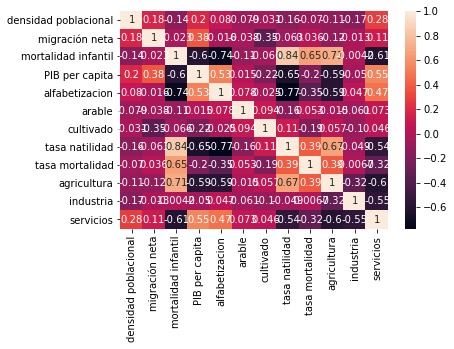

In [90]:

sns.heatmap(df.corr(),annot = True)

Vemos que en nigún caso hay alguna correlación fuerte, curiosamente la correlación más fuerte, 0.84, se encuentra entre la mortalidad infantil con la tasa de natalidad. Este hecho resulta interesante pues entre más nacimientos hay, también incrementa la mortalidad infantil. La correlación negativa más alta (en valor absoluto) resultó ser alfabetzación y tasa de natalidad con -0.77 lo cual indica que a mayor alfabetización menor es la tasa de natalidad. Cerca de ese valor se encuentra alfabetización con mortalidad infantil con 0-.74, resulta interesante que estás 3 variables estén altamente correlacionadas.

El resto de las variables suelen tener poca correlación con el resto de las variables, esto puede indicar que tienen mayor grado de independencia (aunque no es posible concluir independencia). Realizamos una gráfica de pairplot para entender mejor la relación entre las variables.

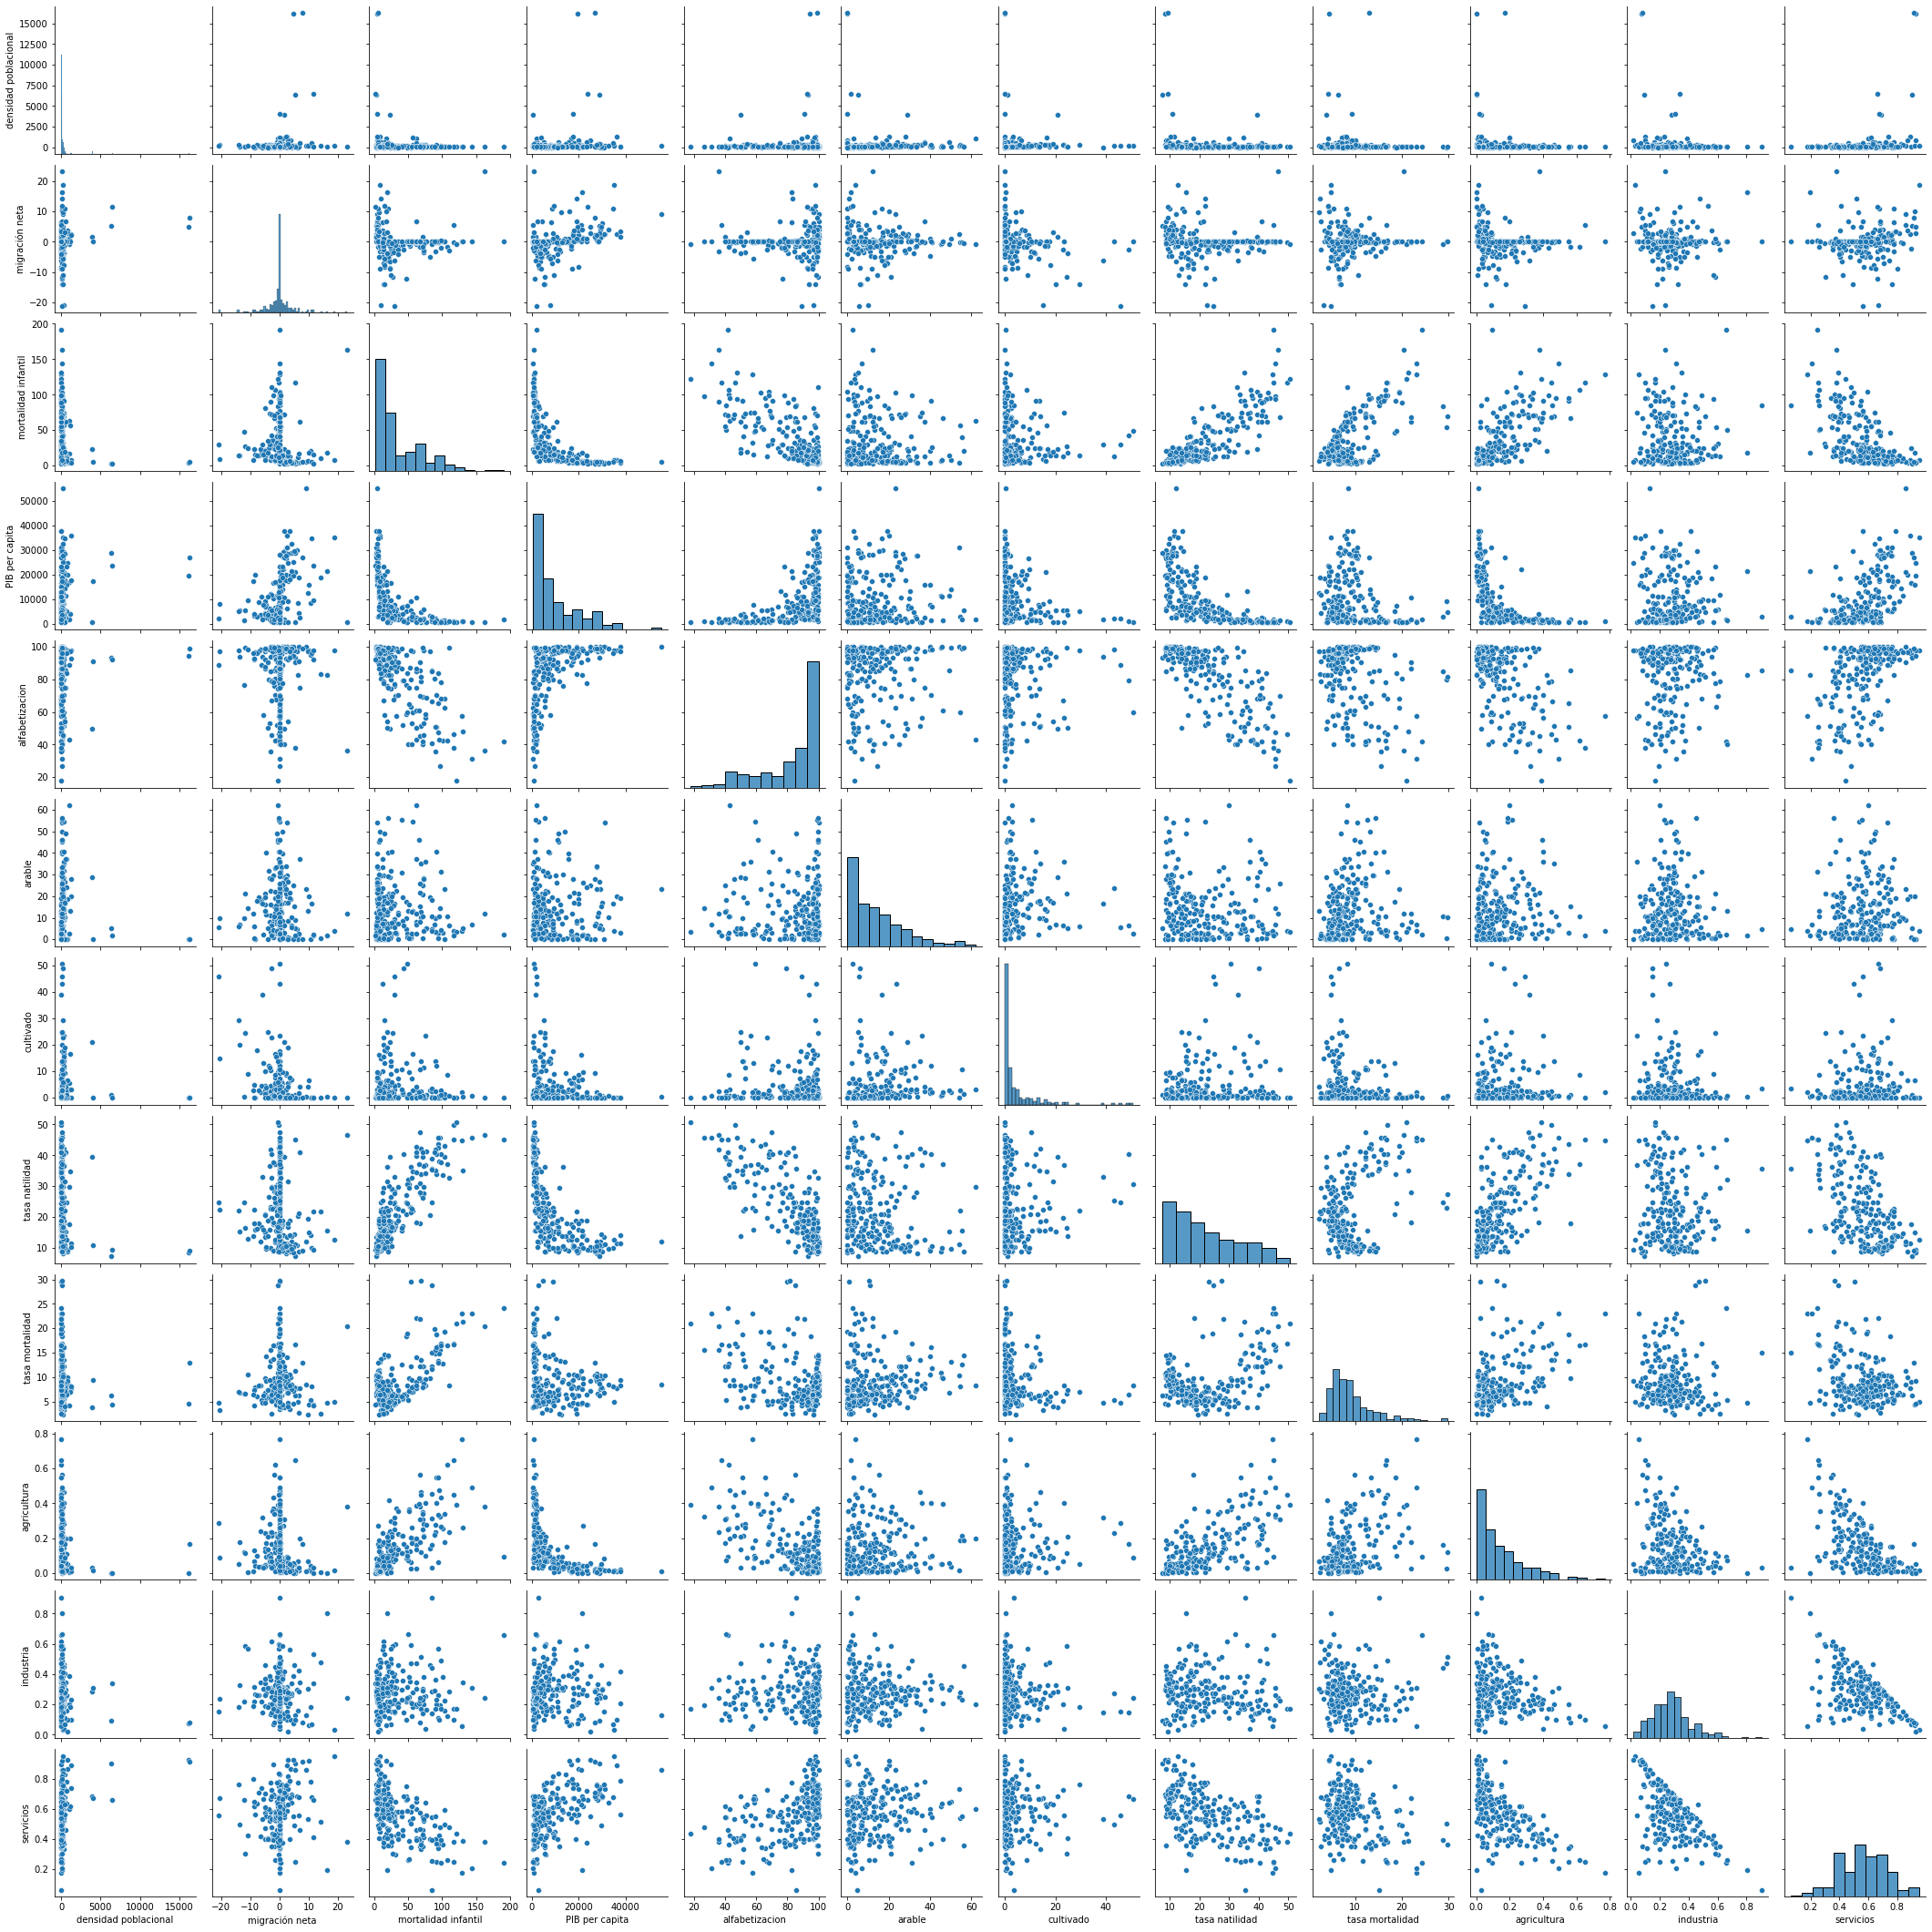

In [121]:
sns.pairplot(df)

Primero analicemos los histogramas. Observamos que existen varias relaciones entre las variables, vemos que en pocos casos la distribución empírica tiene simetría por lo que los datos tienden a tener colas peadas. Esto muestra que hay muchos países con datos extremos. También destacan algunas variables como el área cultivada, la alfabetización y la densidad poblacional que tienen una moda muy pronunciada. Por lo que no esperamos que haya mucha varianza en estos datos y esperamos que el PCA logre reducir dichos componentes. La migración neta es la única variable que sí muestra simetría y con relativamente colas poco pesadas ( a comparación del resto de los casos), esto hace sentido considerando que hay países que son receptores de migrantes mientras que otros emiten pero el número neto de entradas menos salidas a escala mundial debe ser cero. 

Ahora considerando los scatter plots vemos distintos comportamientos. En la mayoría de los casos los puntos suelen agruparse en algún punto o sobre un a recta o curva, tal es el caso de la gráfica industria vs. servicios donde hay un limíte que los puntos no sobrepasan indicando la relación inversa que existen entre estas variables. Otro caso interesante es la relación de PIB per capita vs. agricultura pues vemos que el patrón es el de una curva decreciente muy pronunciada conforme se acerca a 0 esta actividad económica. Podemos interpretar que economías muy dependientes de la agricultura tienden a generar poca riqueza pero que tener poco peso en la economía de este sector no garantiza que se incremente el PIB. Un análisis análogo se puede hacer con otras variables como el de PIB per capita vs. alfabetización pero en un sentido inverso. En general, vemos que la densidad poblacional no representa un papel importante en comparación del resto de variables pues los puntos suelen permanecer constantes conforme se mueven los otros parámetros. Finalmente, hay otros casos en donde solo se distingue una nube de puntos sin un patrón evidente como es el caso de industria con tasa de natalidad indicando que hay poca correlación entre las variables.

Vamos a realizar el algoritmo de Principal Component Analysis (PCA) para reducir la varianza del modelo, y con esto calcular el KMeans. Conservaremos el 95% de varianza. 

In [118]:
pca = PCA(n_components=0.95)
PC = pca.fit_transform(df_normalizado)
pca_df = pd.DataFrame(PC)


In [107]:
print(pca.explained_variance_ratio_.cumsum())

[0.79665287 0.93184093 0.98412436 0.99576339 0.99754961 0.99899442
 0.9996279  0.99989412 0.99999917 0.99999965 0.99999994 1.        ]


Decidimos el número de clusters calculando la inercia, consideramos tomar solo los primeros 7 clusters.

Text(0, 0.5, 'Inercia')

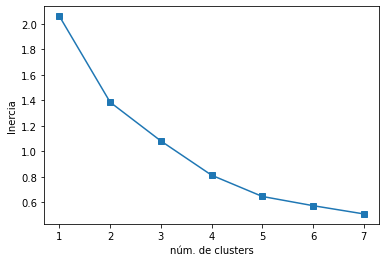

In [119]:

inercia = []

for k in range(1,8):
    clf = cluster.KMeans(random_state=1, n_clusters = k)
    clf.fit(pca_df)
    inercia.append(np.sqrt(clf.inertia_))
    
plt.plot(range(1,8), inercia, marker='s')
plt.xlabel('núm. de clusters')
plt.ylabel('Inercia')

Aunque es subjetivo el número de cluster adecuado, consideramos que a partir del 4° punto hay un punto de inflexión y la inercia se ha reducido adecuadamente, por lo que se considera 4 clusters para el modelo. Otro punto adecuado podría ser 3, pero consideramos que tener una inercia menor a 1 puede ser mejor y puede haber un análisis más claro de las variables.

Ahora procedemos a calcular las K medias y graficamos nuevamente el pairplot pero ahora tomando en cuenta los clusters.

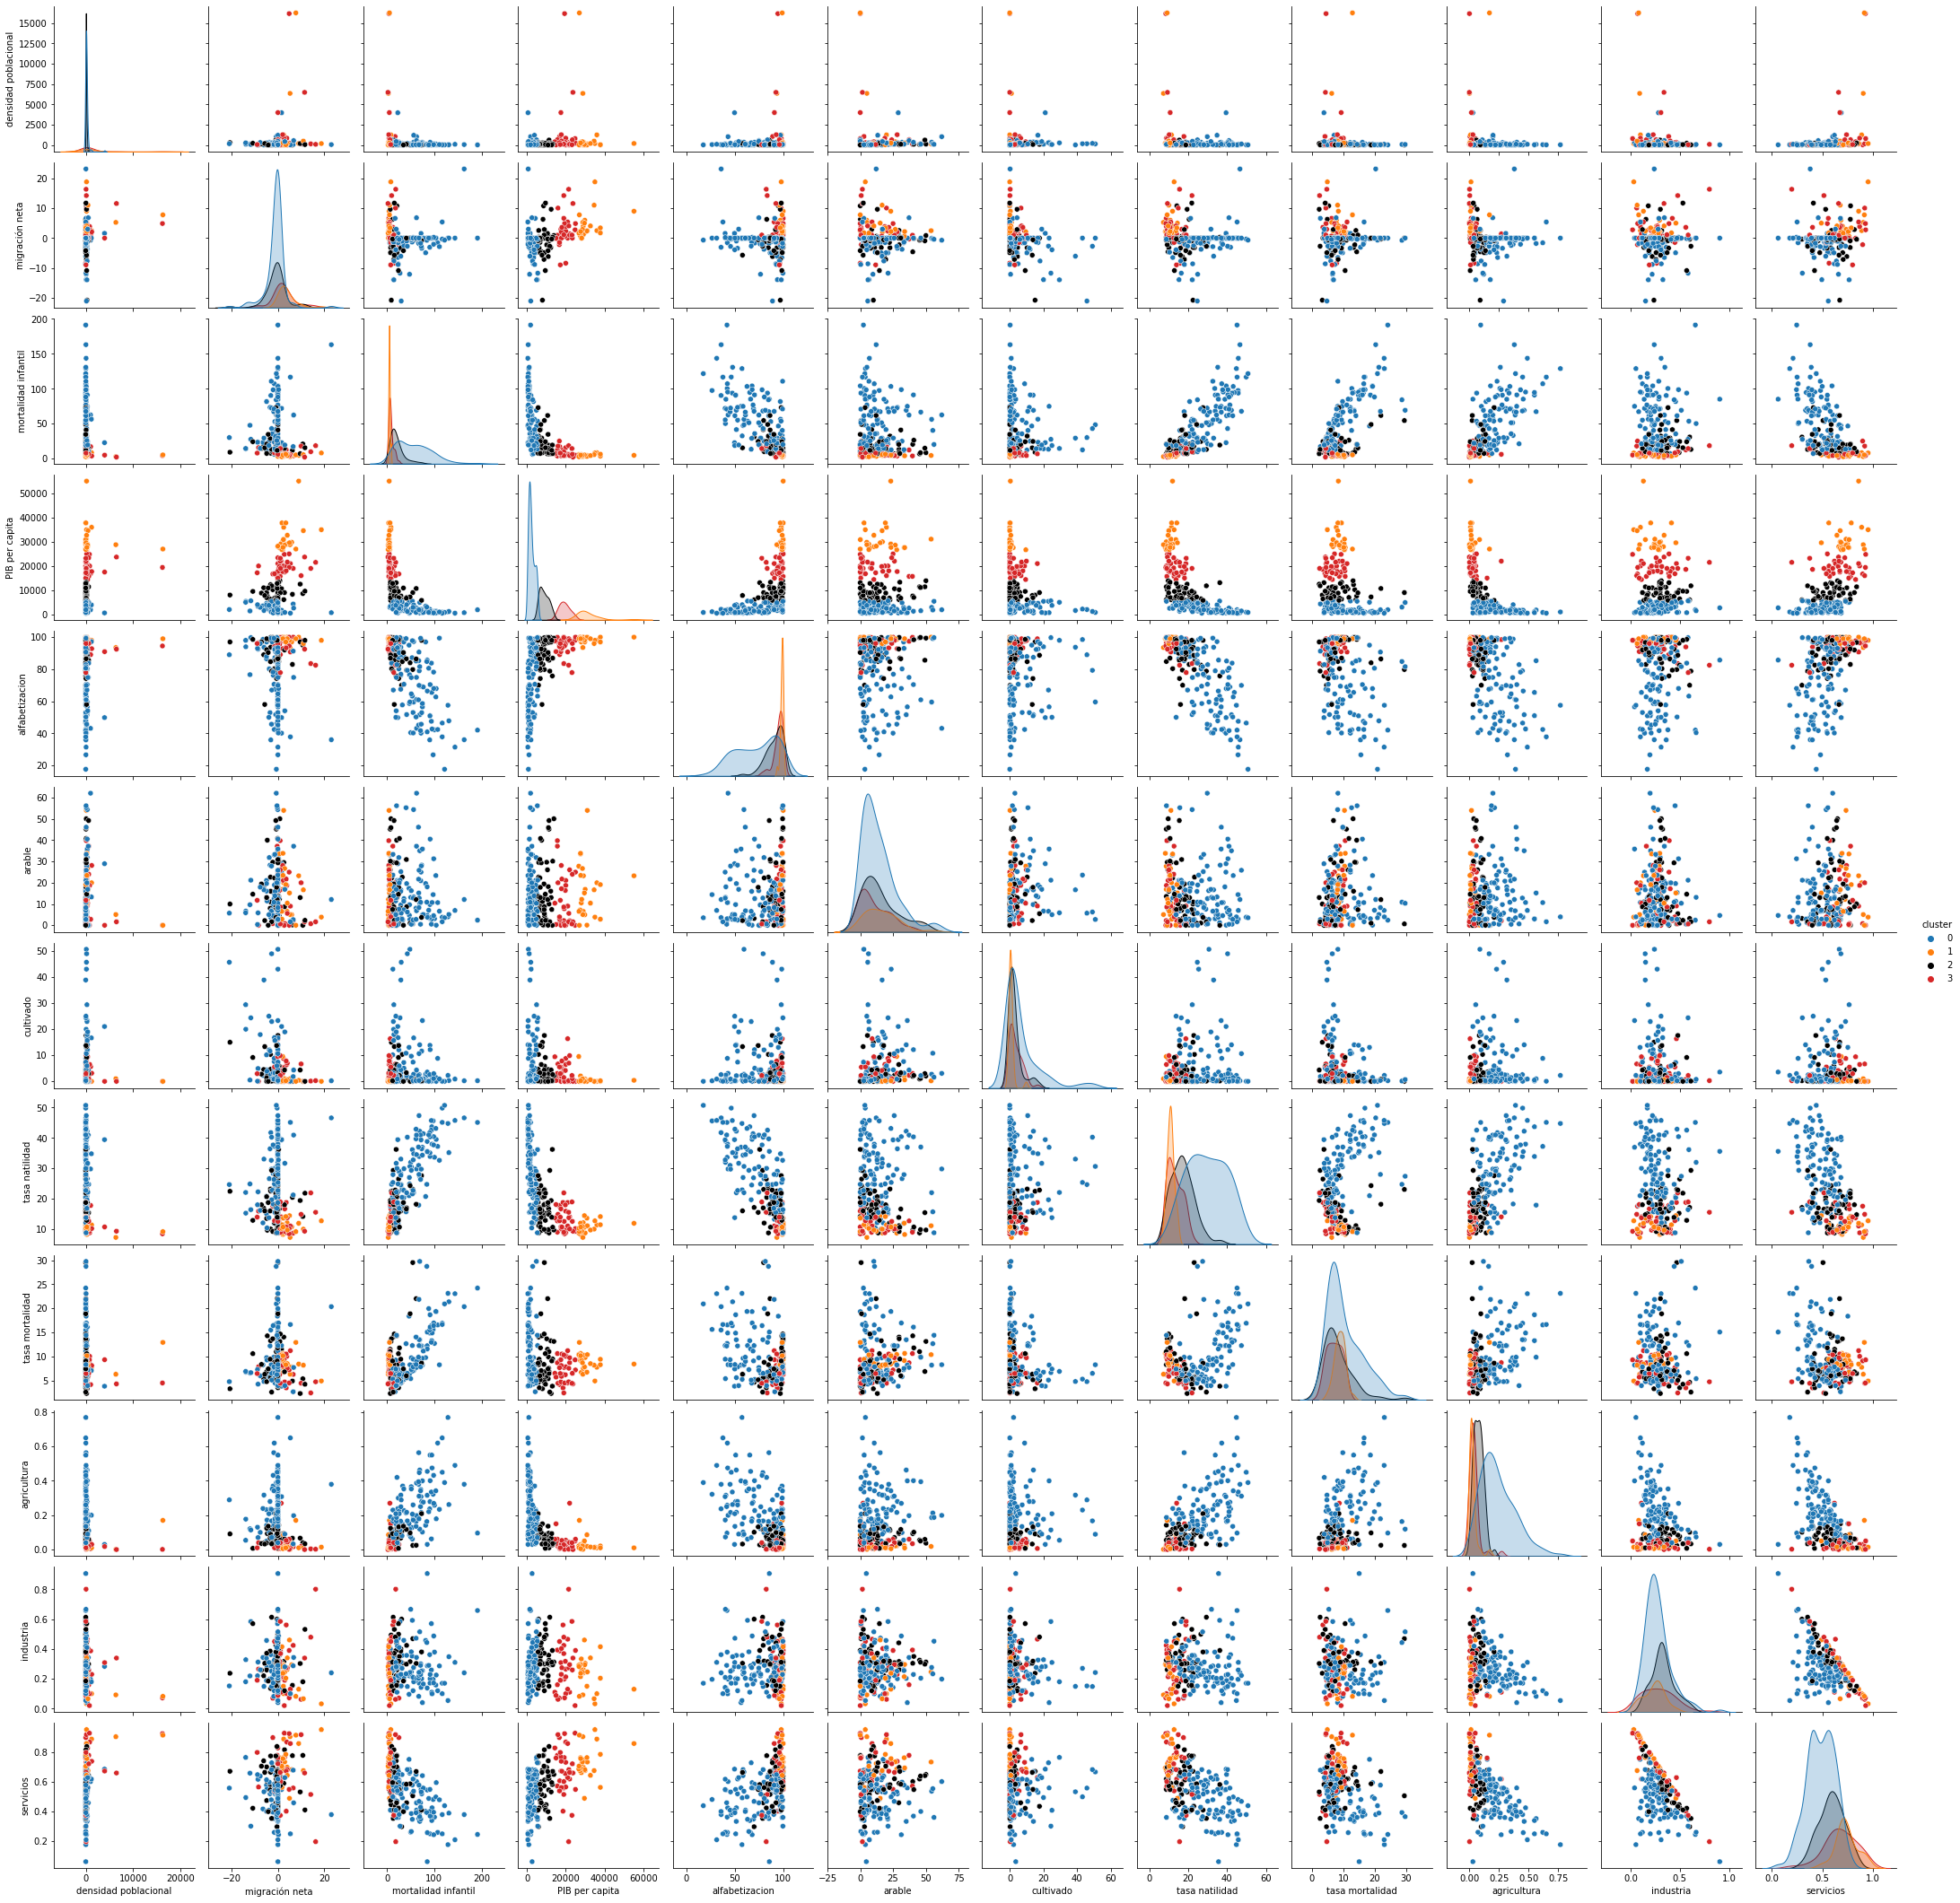

In [185]:
clf = cluster.KMeans(random_state=1, n_clusters = 4).fit(df)
etiquetas = pd.DataFrame(clf.labels_)
df_etiquetado = pd.concat((df,etiquetas), axis=1)
df_etiquetado = df_etiquetado.rename({0: 'cluster'}, axis=1)
sns.pairplot(df_etiquetado,hue='cluster', palette = ["C0", "C1", "k","C3"])

Es claro ver que los puntos azules son los más dispersos en todos los gráficos, por lo que deben ser los de mayor varianza, el resto de los puntos suelen estar más agrupados. El segundo grupo más disperso son los puntos negros que corresponden al siguiente grupo de los azules.

Esto puede indicar que los países con menor calidad de vida tienen realidades más distintasy sus deficiencias son más extremas provocando que haya más puntos outliers. Otro punto interesante a notar es que el PIB per capita es donde es mejor ver la separación de cada clusters. Por tanto, el PIB per capita puede ser una variable a considerar cuando se quiere medir la calidad de vida en los países.

Otro patrón interesante lo vemos en las gráficas de migración neta, los puntos de los países ricos suelen concentrarse del lado derecho mientras que los puntos azules sueln concentrarse en el lado izquierdo, un comportamiento intereseante que muestra el movimiento humano de los países pobres a los países ricos. La gráfica con cluster más dispersos corresponde a arable vs. industria lo que muestra la poca relación y poco que explica el modelo estas variables, encontramos otros casos parecidos en tasa mortalidad vs. industria y migración neta vs. densidad poblacional.

Las gráficas de densidad en cada variable muestran la gran varianza que tienen los países azules pues son más anchas y sus picos son más altos porque son el grupo más numeroso. Es interesante ver el comportamiento del PIB per capita pues los grupos muestran un evidente decrecimiento en cantidad de países y un aumento en el nivel de capital. Esto muestra la distribución de la riqueza, son pocos los paíss que acumulan la mayor parte de la riqueza, y la mayoría viven en la pobreza.

Si no consideramos el cluster azul vemos que los otros cluster tienen una tendencia a estar más agrupados pero sigue siendo clara la diferencia que hay entre éstas. Por ejemplo, el cluster naranja están más agrupados, suelen tener mejores indicadores como menor tasa de natalidad, mayor tasa de alfabetización, economía más dinámica, etc...

Ahora retomamos el gráfico T-SNE hecho anteriormente pero ahora con los clusters calculados.

[Text(0.5, 1.0, 'T-SNE proyección')]

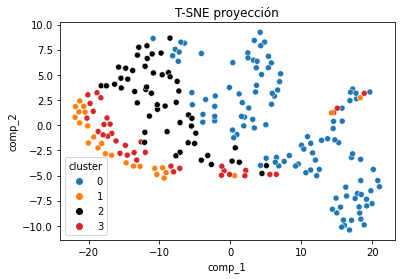

In [157]:
df_etiquetado['comp_1'] = tsne[:,0]
df_etiquetado['comp_2'] = tsne[:,1]

sns.scatterplot(x="comp_1", y="comp_2", hue='cluster', palette = ["C0", "C1", "k","C3"],data=df_etiquetado).set(title="T-SNE proyección")


Vemos que el patrón se repite al caso anterior en el que los puntos naranjas se encuentran más agrupados y los puntos azules más dispersos. También es de notar que hay algunos puntos outliers de los clusters naranjas y rojos posiblemente correspondientes a países con alta densidad poblacional, poco terreno arable y cultivado pero con alto nivel de alfabetización y PIB per capita como Hong Kong, Singapur. Otro aspecto a destacar son los puntos que se encuentran en el tercer cuadrante, el de los negativos en ambas coordenadas, que son principalmente naranjas y rojos mientras que los que se encuentran en el primer cuadrante y cuarto cuadrante son los azules. 

Ahora contamos el número de observaciones de cada cluster.

In [158]:
print('Del grupo 0 hay ' + str(sum(df_etiquetado['cluster']==0)) + ' países.')
print('Del grupo 1 hay ' + str(sum(df_etiquetado['cluster']==1)) + ' países.')
print('Del grupo 2 hay ' + str(sum(df_etiquetado['cluster']==2)) + ' países.')
print('Del grupo 3 hay ' + str(sum(df_etiquetado['cluster']==3)) + ' países.')

Del grupo 0 hay 114 países.
Del grupo 1 hay 25 países.
Del grupo 2 hay 53 países.
Del grupo 3 hay 35 países.


Vemos que el 50.22% corresponde a puntos del cluster 0, 11.01% corresponde a países del cluster 1, 23.34% corresponden al cluster 2 y 15.41% corresponden a países del conjunto 3. Es claro que el conjunto más grande es el cluster 0 que corresponden a poco más de la mitad de los puntos. El siguiente conjunto corresponde a  los países del cluster 2. En conjunto, forman cerca del 75% de los países. Es interesante notar que tales países forman parte de los países considerados "más pobres". Esta proprción deja en evidencia la desigualdad que existe entre las distintas naciones del mundo pues tres cuartas partes de los países se encuentran en los clusters com los atributos menos desarrollados.

Sin embargo, hasta ahora no sabemos qué países corresponden qué cluster, vamos a imprimir los países que pertenecen a cada cluster y analizar algunas de sus similtudes.

In [186]:
df_etiquetado.insert(0, 'Países', raw_data['Country'])

In [191]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(df_etiquetado[df_etiquetado['cluster']==0])

,Países,densidad poblacional,migración neta,mortalidad infantil,PIB per capita,alfabetizacion,arable,cultivado,tasa natilidad,tasa mortalidad,agricultura,industria,servicios,cluster
0,Afghanistan,48.0,23.06,163.070,700.0,36.00,12.130,0.220,46.600,20.340,0.3800,0.2400,0.3800,0
1,Albania,124.6,-4.93,21.520,4500.0,86.50,21.090,4.420,15.110,5.220,0.2320,0.1880,0.5790,0
5,Angola,9.7,0.00,191.190,1900.0,42.00,2.410,0.240,45.110,24.200,0.0960,0.6580,0.2460,0
9,Armenia,99.9,-6.47,23.280,3500.0,98.60,17.550,2.300,12.070,8.230,0.2390,0.3430,0.4180,0
13,Azerbaijan,91.9,-4.90,81.740,3400.0,97.00,19.630,2.710,20.740,9.750,0.1410,0.4570,0.4020,0
16,Bangladesh,1023.4,-0.71,62.600,1900.0,43.10,62.110,3.070,29.800,8.270,0.1990,0.1980,0.6030,0
20,Belize,12.5,0.00,25.690,4900.0,94.10,2.850,1.710,28.840,5.720,0.1420,0.1520,0.6120,0
21,Benin,69.8,0.00,85.000,1100.0,40.90,18.080,2.400,38.850,12.220,0.3160,0.1380,0.5460,0
23,Bhutan,48.5,0.00,100.440,1300.0,42.20,3.090,0.430,33.650,12.700,0.2580,0.3790,0.3630,0
24,Bolivia,8.2,-1.32,53.110,2400.0,87.20,2.670,0.190,23.300,7.530,0.1280,0.3520,0.5200,0


In [187]:
display(df_etiquetado[df_etiquetado['cluster']==1])

,Países,densidad poblacional,migración neta,mortalidad infantil,PIB per capita,alfabetizacion,arable,cultivado,tasa natilidad,tasa mortalidad,agricultura,industria,servicios,cluster
10,Aruba,372.5,0.00,5.89,28000.0,97.0,10.53,0.00,11.03,6.68,0.004,0.333,0.6630,1
11,Australia,2.6,3.98,4.69,29000.0,100.0,6.55,0.04,12.14,7.51,0.038,0.262,0.7000,1
12,Austria,97.7,2.00,4.66,30000.0,98.0,16.91,0.86,8.74,9.76,0.018,0.304,0.6780,1
19,Belgium,340.0,1.23,4.68,29100.0,98.0,23.28,0.40,10.38,10.27,0.010,0.240,0.7490,1
22,Bermuda,1241.0,2.49,8.53,36000.0,98.0,20.00,0.00,11.40,7.74,0.010,0.100,0.8900,1
36,Canada,3.3,5.96,4.75,29800.0,97.0,4.96,0.02,10.78,7.80,0.022,0.294,0.6840,1
38,Cayman Islands,173.4,18.75,8.19,35000.0,98.0,3.85,0.00,12.74,4.89,0.014,0.032,0.9540,1
54,Denmark,126.5,2.48,4.56,31100.0,100.0,54.02,0.19,11.13,10.36,0.018,0.246,0.7350,1
68,Finland,15.5,0.95,3.57,27400.0,100.0,7.19,0.03,10.45,9.86,0.028,0.295,0.6760,1
69,France,111.3,0.66,4.26,27600.0,99.0,33.53,2.07,11.99,9.14,0.022,0.214,0.7640,1


In [189]:
display(df_etiquetado[df_etiquetado['cluster']==2])

,Países,densidad poblacional,migración neta,mortalidad infantil,PIB per capita,alfabetizacion,arable,cultivado,tasa natilidad,tasa mortalidad,agricultura,industria,servicios,cluster
2,Algeria,13.8,-0.390,31.000,6000.0,70.00,3.22,0.25,17.14,4.610,0.1010,0.6000,0.2980,2
3,American Samoa,290.4,-20.710,9.270,8000.0,97.00,10.00,15.00,22.46,3.270,0.0910,0.2370,0.6725,2
6,Anguilla,132.1,10.760,21.030,8600.0,95.00,0.00,0.00,14.17,5.340,0.0400,0.1800,0.7800,2
7,Antigua & Barbuda,156.0,-6.150,19.460,11000.0,89.00,18.18,4.55,16.93,5.370,0.0380,0.2200,0.7430,2
8,Argentina,14.4,0.610,15.180,11200.0,97.10,12.31,0.48,16.73,7.550,0.0950,0.3580,0.5470,2
18,Belarus,49.6,2.540,13.370,6100.0,99.60,29.55,0.60,11.16,14.020,0.0930,0.3160,0.5910,2
25,Bosnia & Herzegovina,88.0,0.310,21.050,6100.0,84.80,13.60,2.96,8.77,8.270,0.1420,0.3080,0.5500,2
26,Botswana,2.7,0.000,54.580,9000.0,79.80,0.65,0.01,23.08,29.500,0.0240,0.4690,0.5070,2
27,Brazil,22.1,-0.030,29.610,7600.0,86.40,6.96,0.90,16.56,6.170,0.0840,0.4000,0.5160,2
30,Bulgaria,66.6,-4.580,20.550,7600.0,98.60,40.02,1.92,9.65,14.270,0.0930,0.3040,0.6030,2


In [190]:
display(df_etiquetado[df_etiquetado['cluster']==3])

,Países,densidad poblacional,migración neta,mortalidad infantil,PIB per capita,alfabetizacion,arable,cultivado,tasa natilidad,tasa mortalidad,agricultura,industria,servicios,cluster
4,Andorra,152.1,6.60,4.05,19000.0,100.00,2.220,0.000,8.71,6.25,0.0160,0.4240,0.5595,3
14,"Bahamas, The",21.8,-2.20,25.21,16700.0,95.60,0.800,0.400,17.57,9.05,0.0300,0.0700,0.9000,3
15,Bahrain,1050.5,1.05,17.27,16900.0,89.10,2.820,5.630,17.80,4.14,0.0050,0.3870,0.6080,3
17,Barbados,649.5,-0.31,12.50,15700.0,97.40,37.210,2.330,12.71,8.67,0.0600,0.1600,0.7800,3
28,British Virgin Is.,151.0,10.01,18.05,16000.0,97.80,20.000,6.670,14.89,4.42,0.0180,0.0620,0.9200,3
29,Brunei,65.8,3.59,12.61,18600.0,93.90,0.570,0.760,18.79,3.45,0.0360,0.5610,0.4030,3
52,Cyprus,84.8,0.43,7.18,19200.0,97.60,7.790,4.440,12.56,7.68,0.0370,0.1980,0.7650,3
53,Czech Republic,129.8,0.97,3.93,15700.0,99.90,39.800,3.050,9.02,10.59,0.0340,0.3930,0.5730,3
66,Faroe Islands,33.8,1.41,6.24,22000.0,98.45,2.140,0.000,14.05,8.70,0.2700,0.1100,0.6200,3
71,French Polynesia,65.9,2.94,8.44,17500.0,98.00,0.820,5.460,16.68,4.69,0.0310,0.1900,0.7690,3


Vemos que efectivamente los países considerados en el cluster 1 corresponden a países considerados ricos o con una calidad de vida alta (Muchos de ellos pertenecen al G20). Los países en el cluster 3 con una superficie territorial menor pero de igual manera con buena calidad de vida y alto desarrollo económico. El cluster 2 son también países con buena calidad de vida pero no tan desarrollados como los países anteriores. Finalmente, el cluster 0 es el correspondiente a los países pobres, que es donde se ubica la mayoría, pues no cuentan con buenos servicios, algunos presentan crisis humanitarias y sus economías no están tan desarrolladas. Sin embargo, en cada cluster puede argumentarse que hay excepciones pues sabemos que el agrupamiento puede poner puntos que no pertenecen al cluster en él.

Vamos a analizar los centros de cada cluster para entender mejor el comportamiento de cada uno y qué tipo de asociación tienen entre sí. Vamos a ordenarlos tal como se analizo en el párrafo anterior.

In [192]:
centros = pd.DataFrame(clf.cluster_centers_)
centros.columns = nombres
centros.sort_values(by=['PIB per capita'])

,densidad poblacional,migración neta,mortalidad infantil,PIB per capita,alfabetizacion,arable,cultivado,tasa natilidad,tasa mortalidad,agricultura,industria,servicios
0,160.906140,-1.206930,57.479035,2384.210526,72.086842,13.893991,6.571535,29.635044,10.453158,0.240039,0.275202,0.482820
2,90.098113,-0.875000,20.462358,8867.924528,90.659434,15.026604,2.883962,16.991321,8.332736,0.075792,0.326245,0.589887
3,1012.488571,2.434286,8.412857,19317.142857,94.821429,10.740143,3.360429,13.269143,7.096286,0.038643,0.285171,0.675057
1,1099.524000,3.961200,4.893600,31316.000000,98.440000,16.162000,0.726000,10.833600,8.791200,0.025720,0.234680,0.736500


Vemos que la densidad poblacional es mucho mayor en los países ricos que en los pobres, esto puede a varios puntos outliers como es el caso del cluster 3 donde Macau tiene una densidad poblacional de 16183, o en el cluster 1 donde Monaco tiene una densidad poblacional de 16271.5. Esto muestra lo influyentes que pueden ser los outliers en el algoritmo de K medias. No obstante, en los países de los otros clusters sí tienen una evidente baja densidad poblacional a comparación del otro par por lo que identificamos que no existen outliers tan notables. 

En el caso de la migración neta vemos otro patrón interesante y predecible pues la gente en los países pobres tienen una tendencia a migrar al otro sector de países ricos debido a la mejor calidad de vida, esto se puede entender mejor al estudiar las variables de PIB per capita pues el PIB per capita crece exponencialmente conforme se avanza en los clusters. Recordemos que en esta variable resultaba más evidente la separación entre países. 

Vemos que hay una relación inversa entre la mortalidad infantil y la tasa de natalidad, esto puede entenderse pues si hay más infantes naciendo también hay más probabilidad que mueran pero también muestra la importancia de la planificación familiar con el fin de garantizar la mejor calidad de vida tanto de los niños como de los padres. Además es importante notar el salto importante que hay entre la mortalidad de los clusters más ricos con el cluster 2, y más aún con el cluster 0. Otro punto destacable es que la tasa de natalidad crece de manera lineal en los clusters 3, 2 y 1 mientras que no lo hace de la misma manera la mortalidad infantil que tiene un comportamiento más exponencial. Esto indica que puede haber otros factores que expliquen la alta mortalidad infantil en países más pobres como pueden ser el fácil acceso a servicios de salud.

Otro aspecto a estudiar es la relación entre la tasa de mortalidad y la tasa de natalidad, vemos que la tasa de mortalidad no suele cambiar significativamente a comparaciónde la tasa de natalidad. De aquí podemos concluir que la población en el cluster 0 debe estar incrementandose a una tasa de crecimiento muy alta pues la tasa de natalidad es casi el triple a la de la mortalidad. En cambio, en los países con renta media alta la tasa de natalidad solo es poco más alta a comparación de la de mortalidad. 

En relación al nivel de alfabetización, nuevamente vemos ese cambio notorio entre el cluster 0 y el resto de los clusters pues en el resto de los casos el grado de alfabetización supera los 90 puntos mientras que en el primero solo alcanza los 72. En este conjunto destacan países arriba de los 90 puntos como Cuba, Ucrania o China pero también hay casos preocupantes como varias naciones africanas o asiaticas que están por debajo de los 50 puntos. Esto muestra la gran varianza que hay entre cada país de este cluster y que indica las distintas condiciones que tiene cada país entre el mismo cluster.

Ahora para el caso de porcentaje de tierra arable no hay gran diferencia entre cada cluster pues ambos tienen valores cercanos. En cambio, para el caso de cultivado encontramos que en el cluster 1 el porcentaje es muy pequeño aunado al hecho que la agricultura suele representar tan solo el 2.5% de su economía, la más baja entre todos los clusters. Por otro lado, el cluster 0 es el que tiene el mayor porcentaje de zona cultivada, y por esta misma razón es el cluster con mayor dependencia de la actividad agricultural pues representa el 24% de su economía.

Finalmente, cuando analizamos la composición de su economía vemos comportamientos bastante interesantes pues como se mencionó en el parráfo anterior del cluster 0, la cuarta parte de su economía depende de la agricultura. Mucho mayor al cluster próximo que es de 7.5% y aún distinto, pero en menor medida, del cluster 1 y 3 que es de 3.8% y de 2.5% respectivamente. Otro detalle interesante es que para el caso del sector industrial sus proporciones resultan más parecidos pues el menor peso que es el grupo de los países más ricos es de 23.46% y el de mayor peso es el cluster 2 que tiene un valor de 32% Esto indica que el grupo de los países del cluster 2 son los que más dependen de su sector industrial, aunque esta diferencia no es tan mayor como el del caso de la agricultura. Por último, el sector asociado al de los servicios que incluye transportes, educación, banca, turismo, etc... es el que tiene mayor peso en todos los casos. Aunque es bastante notorio que en los países más desarrollados son los que tienen mayor ponderación pues mientras que en el cluster 1 y 2 el porcentaje oscila entre 67.5% y 73%, en el cluster 0 es de 48.2% y en el cluster 2 de 58.98%. Contrario a lo que puede intuirse inicialmente, una economía con mayor peso en este sector indica que tiene mayor dinamismo y es menos propensa a crisis económicas pues es en este sector donde se encuentran la mayoría de las actividades ecoómicas. Entonces, podemos pensar que una característica muy fuerte en las economías prosperas es su fuerte componente en servicios. También muestra que las naciones donde la actividad agrícola es más predominante son más propensas a tener altos grados de desigualdad. 

En conclusión vemos que la diferencias entre los clusters ricos no suele ser tan distinta a comparación que entre las naciones pobres donde los indicadores suelen ser más extremos con mayor varianza y en general, mayor desigualdad entre ellos. Esto muestra un comportamiento preocupante pues es ahí donde se concentra la mayor parte de la población mundial y la tercer parte de los países analizados. Notamos que el análisis presentado acá no debe pensarse que explica las causas de la desigualdad y pobreza pues dicho análisis se escapa del alcance del presente trabajo, sin embargo sí muestra distintas consecunecias asociadas deribado de ello.